## Data Science Challenge, H-1b Visas

H-1B visa application data 
https://app.enigma.io/table/us.gov.dol.oflc.h1b.2014
 
### Section 1

In [30]:
%matplotlib inline

In [31]:
import pandas as pd
import numpy as np
import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
import statsmodels.api as sm

In [2]:
#open and read the file into a pandas data frame
filename = "C:/Users/Stacey/Downloads/enigma-us.gov.dol.oflc.h1b.2014-56e1326ac5eb020a9c4727d1eb8d96e6.csv"
df = pd.read_csv(filename)

In [5]:
#check that all rows were read in
print len(df)
#view column headers
list(df)

519504


['lca_case_number',
 'status',
 'lca_case_submit',
 'decision_date',
 'visa_class',
 'lca_case_employment_start_date',
 'lca_case_employment_end_date',
 'lca_case_employer_name',
 'lca_case_employer_address',
 'lca_case_employer_city',
 'lca_case_employer_state',
 'lca_case_employer_postal_code',
 'lca_case_soc_code',
 'lca_case_soc_name',
 'lca_case_job_title',
 'lca_case_wage_rate_from',
 'lca_case_wage_rate_to',
 'lca_case_wage_rate_unit',
 'full_time_pos',
 'total_workers',
 'lca_case_workloc1_city',
 'lca_case_workloc1_state',
 'pw_1',
 'pw_unit_1',
 'pw_source_1',
 'other_wage_source_1',
 'yr_source_pub_1',
 'lca_case_workloc2_city',
 'lca_case_workloc2_state',
 'pw_2',
 'pw_unit_2',
 'pw_source_2',
 'other_wage_source_2',
 'yr_source_pub_2',
 'lca_case_naics_code',
 'serialid']

Data Understanding and notes:

* Visa Class: At some point will need to check that Visa Class is always H1-B or only return results for those that are Is the visa class always H1-B?

* City/State: there is location information for the employer as well as up to two job locations for each application - will need to check both job locations to see if they are in NYC

* Total Workers: there may be multiple workers attached to an application - this will have to added to determine number of visas per company, it's not just one per application

* Wage rates can be in several different units, will have to normalize wage rates to annual, or only include annual if these are the majority

In [8]:
#look at the visa classes in the dataset
set(df['visa_class'].tolist())

{'E-3 Australian', 'H-1B', 'H-1B1 Chile', 'H-1B1 Singapore'}

There are three types of H-1B visas and and E-3 Australian, which is a special type of visa, it's not technically an H-1B but is similar enough that we'll leave it in the dataset


#### Section 1, Question 1
Which companies applied for the largest number of H-1B visas where the job opening was located in NYC? Please describe any issues you may encounter summarizing the data by employer name.

Find all jobs where the job opening locations was in 'NYC'

This dataset has two fields for job opening location city and state
'lca_case_workloc1_city', 'lca_case_workloc1_state'
and 
'lca_case_workloc2_city', 'lca_case_workloc2_state'

This analysis will consider both locations, so if either job location 1 or job location 2 is in NYC these will be counted

In [11]:
#check that the state names are normalized, check all states that 
#contain an 'N'
dfStateNY = df[ (df['lca_case_workloc1_state'].str.lower().str.contains('n') == True )]
set(dfStateNY['lca_case_workloc1_state'].tolist())

{'IN', 'MN', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'TN'}

State names appear to be normalized

In [13]:
#Check NY cities
citiesNY = df[ df['lca_case_workloc1_state'].str.lower().str.contains('ny') == True ]\
['lca_case_workloc1_city']
set(citiesNY)

{'#35620 OZONE PARK NY MSA',
 '* 6. POSTAL CODE * PREVAIL',
 '1 COURT SQUARE',
 '110 WEST FAYETTE STREET',
 '13 W.100TH STREET, APT. 4B',
 '132 HARRISON PLACE',
 '137 VARICK STREET, 2ND FLOOR',
 '13TH FLOOR',
 '160 CONVENT AVENUE',
 '160 FORT WASHINGTON AVENUE',
 '227 EAST 56TH STREET',
 '325 HUDSON STREET, 9TH FLOOR',
 '348 LAKE ROAD',
 '43-34 32ND PLACE',
 '5 TIMES SQUARE',
 '55 WATER STREET',
 '630 WEST 168TH STREET',
 '650 WEST 168TH STREET',
 '6TH FLOOR',
 '6TH FLOOR, ROOM 6027W',
 '701 WEST 168TH STREET',
 '7980 TURIN RD., BLDG. 1',
 '7TH FLOOR',
 'ADAMS CENTER',
 'AGRYLE',
 'AIRMONT',
 'ALBANY',
 'ALBANY NY 12237',
 'ALBERTSON',
 'ALBION',
 'ALDEN',
 'ALEXANDRIA BAY',
 'ALFRED',
 'ALTAMONT',
 'AMHERST',
 'AMITYVILLE',
 'AMSTERDAM',
 'ANGOLA',
 'ANNANDALE',
 'ANNANDALE ON HUDSON',
 'ANNANDALE-ON-HUDSON',
 'ARDSLEY',
 'ARGYLE',
 'ARMONK',
 'ARMONK,',
 'ARVERNE',
 'ASTORIA',
 'ATLANTA',
 'AUBURN',
 'AUBURNDALE',
 'AURORA',
 'AUSTIN',
 'BABYLON',
 'BALDWIN',
 'BALITMORE',
 'BALLSTON

For the purpose of this challenge and in the interest of time, the code here will only identify applications where the job location city 1 or 2 
contains "NYC" or "New York City" specifically.

The city names for these fields do not appear to be chosen from a drop down list as there is a lot of variety in the way that cities that are part of NYC are referenced, including "NYC", "New York","Brooklyn", "Bronx", "Downtown Brooklyn", "Manhattan, New York", etc.  In addition there are misspellings of these names.

A more rigorous method would be needed to catch all possible NYC references, in addition to misspellings.

In [15]:
#identify New York City cities
nycCities = 'nyc|new york city'
#get only cases where city 1 or city 2 is in New York

In [17]:
#create a function to subset the data to get only data for specific cities
def cities(cityNames):
    """
    This function takes the city names and outputs all rows where work location
    1 or work location 2 is equal to that city name.
    """
    dfCity = df[ (df['lca_case_workloc1_city'].str.lower().str.contains(cityNames) == True )\
    | (df['lca_case_workloc2_city'].str.lower().str.contains(cityNames)== True) ]
    return dfCity

dfNyc = cities(nycCities)


In [18]:
#subset the data to just get specific fields
def dfSubset(dfCity,field1,field2):
    """
    This function takes the city specific dataframe and two fields and returns a 
    subset of the dataframe with the specified fields
    """
    dfCitySubset = dfCity[ [field1,field2] ]
    return dfCitySubset


In [19]:
#get a subset of the NYC data with employer name and total workers
dfNycWorkers = dfSubset(dfNyc,'lca_case_employer_name','total_workers')
dfNycWorkers

,lca_case_employer_name,total_workers
71,NUL SYSTEM SERVICES CORPORATION,1.0
593,"SECONDMARKET HOLDINGS, INC.",1.0
1318,"BAIN AND COMPANY, INC.",1.0
3046,EDWARDS LIFESCIENCES LLC,1.0
3621,"BAIN AND COMPANY, INC.",1.0
4925,VERINON TECHNOLOGY SOLUTIONS LTD.,1.0
6914,IMETRIS CORPORATION,1.0
7295,CBS INTERACTIVE INC.,1.0
7394,"V-SOFT CONSULTING GROUP, INC",1.0
7614,"WOOD MACKENZIE, INC.",1.0


In [20]:
#group by company and sum the number of workers    
nycWorkers = dfNycWorkers.groupby(['lca_case_employer_name']).sum()

In [21]:
#get the employer with the maximum number of workers and what that max is
nycMaxWorkers = nycWorkers[['total_workers']].max()
print(nycMaxWorkers)
#determine which employer this is
nycWorkers[ nycWorkers['total_workers'] == float(nycMaxWorkers)].index.tolist()

total_workers    30.0
dtype: float64


['MPHASIS CORPORATION']

#### Section 1, Question 1 Results:

The result was that The NYC/New York City employer applying for the greatest number of visas was 'MPHASIS CORPORATION' with 30 total workers.

Simplifications: 

In the interest of time, this analysis only looked at applications where work location 1 or 2 was “NYC” or “New York City”, and employer names were not adjusted before consolidation. 

Issues Encountered:
* Several issues were encountered in this analysis. The first is that while the state name is the standard two letter state code, the city names used for work locations do not appear to be standardized (i.e. selected from a drop down menu). Rather, there are many ways in which New York City is referred to by various employers including “NYC”, “New York City”, “Brooklyn”, “Manhattan”, etc.  In addition in some cases there are misspellings of these names.  

* The next issue encountered is with the employer name. The same employer name can be spelled in a number of ways:

  * Some companies had names with punctuation for one application and none in their name for another: INFOCEPTS LLC vs INFOCEPTS, LLC vs INFOCEPTS. Punctuation and suffixes (LLC, INC, etc) could be removed to resolve this issue
  * Some companies have multiple divisions: GOLDMAN SACHS EXECUTION & CLEARING L.P., GOLDMAN SACHS SERVICES LLC , GOLDMAN, SACHS & CO.  This issue is more difficult to resolve as there would need to be an automated way to identify that these are all variations of “GOLDMAN SACHS”. Even referring to the official SEC company name list (https://www.sec.gov/rules/other/4-460list.htm) wouldn’t immediately resolve the issue as the official name there is: 
      * Goldman Sachs Group Inc. This problem would require a normalizing algorithm  (as described here https://www.addaptive.com/blog/using-algorithms-normalize-company-names/) or   Name Entity Recognition   (as described here: https://nlp.stanford.edu/software/CRF-NER.shtml)


#### Section 1, Question 2
Calculate the mean and standard deviation of wages proposed for workers 
located in New York City and Mountain View. Are the average wages in these two locations statistically different? What factors could explain the results?


Data understanding on wage rates:

* WAGE RATE FROM: Employer’s proposed wage rate
* WAGE RATE TO: Maximum proposed wage rate
* WAGE RATE UNIT: Unit of pay. Valid values include “Hour", "Week", "Bi-Weekly", "Month", or "Year"
* FULL TIME POSITION: Y = Full Time Position; N = Part Time Position
    * For the purpose of the wage analysis in this section, wages for part time will be used as though they were full time

Determine how many applications have annual wage units vs. other units.  If more than 80% are annual, then simplify by using only those applications that have annual wages, so other types of wages won't need to be normalized to annual.

In [22]:
#Get the number of jobs that fall into each unit category
def units(dfCity):
    """
    This function takes the city specific dataframe and produces a subset of the
    dataframe with unit type and wage rate, and also calculates the 
    distribution of wages by unit type
    """
    units = dfCity[['lca_case_wage_rate_from','lca_case_wage_rate_unit','total_workers']]
    unitWorkers = units.groupby(['lca_case_wage_rate_unit']).sum()
    return units, unitWorkers


In [23]:
#get the units dataframe and distribution by unit for NY    
unitsNyc, unitWorkersNyc = units(dfNyc)
unitWorkersNyc.iloc[:,1]

lca_case_wage_rate_unit
Hour     42.0
Week      2.0
Year    465.0
Name: total_workers, dtype: float64

In [24]:
#get the dataframe for Mountain View
dfMv= cities('mountain view')

#get the distribution by unit for Mountain View
unitsMv, unitWorkersMv = units(dfMv)
unitWorkersMv.iloc[:,1]

lca_case_wage_rate_unit
Bi-Weekly        1.0
Hour            85.0
Month            3.0
Year         11634.0
Name: total_workers, dtype: float64

Greater than 90% of the applications by total workers are annual. To simplify for the purpose of this exercise, only applications where the proposed wage unit was annual will be considered.

In [26]:
#Calculate mean and standard deviation

def wages(units):
    """
    This function takes the units dataframe and calculates the mean and 
    standard deviation of the wages for annual workers and outputs the list
    of wages
    """
    #get the mean and standard deviation by unit type
    avgWageCity = units.groupby(['lca_case_wage_rate_unit']).mean()
    sdWageCity = units.groupby(['lca_case_wage_rate_unit']).std()
    #get the mean and standard devaiation for annual wages only
    yearWageMean = avgWageCity.loc['Year','lca_case_wage_rate_from'].tolist()
    yearWageStd = sdWageCity.loc['Year','lca_case_wage_rate_from'].tolist()
    
    #get the list of annual wages
    annWageCity = units[units['lca_case_wage_rate_unit'] == 'Year']['lca_case_wage_rate_from']
    print( [round(yearWageMean,2),round(yearWageStd,2)] )
 
    return yearWageMean, yearWageStd, annWageCity


In [27]:
#get average and standard deviation of annual wages for NYC and Mountain View
avgWageNyc, stdWageNyc, annWageNyc = wages(unitsNyc)
avgWageMv, stdWageMv, annWageMv = wages(unitsMv)

[82195.14, 36408.09]
[112573.89, 30730.94]


To test if the means are statistically different, we can use a t-test if both distributions are approximately normal and the population variances are equal.

A QQ plot can be used to check for normality, while an F test can be used to check for equal variance.

If these conditions are not satisfied we will need to use a non-parametric test, such as a KS test

In [28]:
def qqPlot(valList):
    """
    This function produces a QQ plot for a distribution entered as a list of 
    numbers (float)
    """
    stats.probplot(valList, dist="norm", plot=pylab)
    pylab.show()

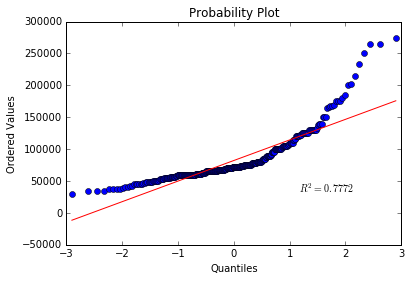

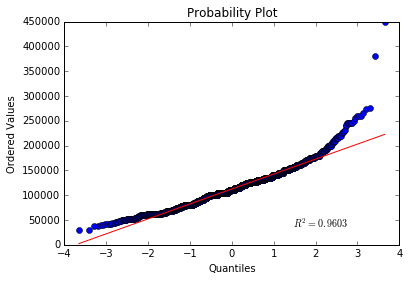

In [32]:
#New York City QQ plot
qqPlot(annWageNyc.tolist())  #the New York City plot is not close to normal
#Mountain View QQ plot
qqPlot(annWageMv.tolist())  #the Mountain View Plot is close to normal, except at the the tails.


Because the New York City distribution is not a normal distribution, a 
non-parametric test is needed instead of t-test to determine if the means are statistically different

In [33]:
#run a KS test
t,p = stats.ks_2samp(annWageNyc.tolist(), annWageMv.tolist())
print('p = ',p)
if p < 0.05:
    print('significant')
else:
    print('not significant')
    

('p = ', 2.4090574240365934e-87)
significant


The distribution of wages for New York City did not resemble a normal 
distribution so a non-parametric test was used to test whether the average wages of Mountain View are different from NYC. The results is that they are statistically significant: the means are different. The mean for Mountain View is \$112,574 is higher than the mean for 
NYC which is $82,195.

The following factors could explain the results:
  *  This analysis was simplified to only include companies where location 1 or location 2 is "NYC" or "New York City", however there are many variations on these names so not all of NYC is being captured in this data such that it might not be representative of New York City wages for H-1B visas.
  *	The cost of living may be higher in Mountain View than in NYC, leading to higher salaries. This would require an additional data source to verify
  *	The number and/or types of jobs for which visas are being requested in Mountain View may be higher paying or have lower supply or higher demand, than those in NYC

#### Section 1, Question 3
For NYC, what is the relationship between the total number of H-1B visas requested by an employer and the average wages proposed? Visually represent this relationship if appropriate. Is the relationship statistically significant? What might explain this relationship?

In [34]:
#get applications with annual wages for NYC
dfNycAnn = dfNyc[dfNyc['lca_case_wage_rate_unit'] == 'Year']
#subset to just three fields
dfNycWages = dfNyc[ ['lca_case_employer_name','total_workers','lca_case_wage_rate_from'] ]
#group by employer and summ the number of workers
nycWages = dfNycWages.groupby(['lca_case_employer_name']).mean()['lca_case_wage_rate_from'].tolist()
nycWorkers = dfNycWages.groupby(['lca_case_employer_name']).sum()['total_workers'].tolist()

(0, 300000.0)

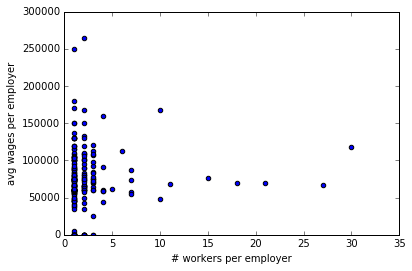

In [35]:
#plot the scatter plot
pylab.scatter(nycWorkers,nycWages)
pylab.xlabel('# workers per employer')
pylab.ylabel('avg wages per employer')
pylab.xlim(0,)
pylab.ylim(0,)

In [36]:
#calculate the correlation
stats.pearsonr(nycWorkers,nycWages)

(0.065496463548107314, 0.31846870871692534)

The correlation is very weak at 0.065, and the p-value of 0.318 is greater than 0.05 so this correlation is not signficant. There is no statistically signficant relationship between the number of workers and average proposed wage rates.

Based on the scatter plot, only a small percentage of companies have applications with more than 5 jobs and there is no obvious pattern between average wages and the number of positions.

#### Section 2
What interesting questions might this dataset address? Brainstorm a handful of interesting questions, and scope them. Describe steps, methodology, and level of effort that would be required to answer each question. Additional, enriching, datasets are allowed, but not required.

#### Section 2 Response

** Question 1 **

How do the proposed wages compare to the prevailing wages? Are they higher or lower. Are there differences by location - do some consistently pay more/less than the prevailing wage?  The same question could also be asked by industry and occupation.

Steps:  
1- Determine which cases have proposed wages that are (10%) higher/lower than prevailing, or (25%) higher/lower than the prevailing.  
2 - As a percentage determine which states have the largest percentage of cases with 10%/25% higher/lower proposed wages  
3 - Drill down by employer, occupation, or industry to determine what might be driving these differences.  

Level of Effort: Easy to Moderate  



** Question 2 **

Can we predict the status of an application: which applications are likely to be certified? Status can be "Certified","Certified-Withdrawn","Denied", and "Withdrawn"

** Option 1 **

Steps:   
1 - Data Exploration of the following possible features: submission month (does season or time of year make a difference), length of employment, Full Time vs Part Time, number of workers, Location (group by region to simplify), Proposed wage rate higher or lower than prevailing   
2 - Narrow to the 3 features based on data exploration   
3 - Since we don't have enough information about "withdrawn"   applications, remove these from the data set, include only "Certified" and "Denied"  
4 - Run a logistic regression to identify which combination of features are predictive of an application being certified.
Level of effort: moderate  

** Option 2 **

Steps:  Steps 1 through 3 above and then

4- Set aside a random sample of 20% as a holdout set for final testing  
5- Divide the remaining 80% into testing and training sets, consider a balanced training set (equal number of certified and not certified) if there are many more non certified than certified applications  
6 - build a few different models - options include a tree model and logistic regression, since this is a supervised learning problem and has a binary outcome.  
7 - A learning curve can be used to determine the size of the training set, and for the tree model a fitting curve can be used to determine the number of levels in the tree  
8 - Build the two models using the training data  
9 - Evaluate the models by analyzing the confusion matrix - if we assume that it is time consuming to create an application and costly if it isn't certified since the company can't hire the people they need, then we want to reduce false positives (predicting the application will be certified when it isn't), so we want to optimize on precision   
10 - Use an ROC curve (true positive rate vs. false positive rate) and the AUC to compare these models to each other and to the random model.  
11 - Unless one model is clearly better than the other, apply both models to the holdout set and apply the above testing methods to determine which model is better  
Level of effort: high

** Question 3 **

For applications that are certified, can we predict the time to certification (decision date - submit date)

Steps:

Option 1 - create a binary target variable where time to certification is either long or short and follow similar steps to question 2. Level of effort: moderate  

Option 2 - Follow similar steps for question 2, but use linear regression/ordinary least squares since the target is a continuous rather than catagorical variable.  level of effort - high  


#### Section 3
Choose a question to answer from your brainstorming section. 

Answer to Question 2 using the option 1 - the moderate effor solution of data exploration and a logistic regression.

Can we predict the status of an application: which applications are likely to be certified? Status can be "Certified","Certified-Withdrawn","Denied", and "Withdrawn

** Step 1 **  
Data Exploration of the following possible features: submission month (does season or time of year make a difference), length of employment, Full Time vs Part Time, number of workers, Location (group by region to simplify), Proposed wage rate

In [37]:
#get list of field names
list(df)

['lca_case_number',
 'status',
 'lca_case_submit',
 'decision_date',
 'visa_class',
 'lca_case_employment_start_date',
 'lca_case_employment_end_date',
 'lca_case_employer_name',
 'lca_case_employer_address',
 'lca_case_employer_city',
 'lca_case_employer_state',
 'lca_case_employer_postal_code',
 'lca_case_soc_code',
 'lca_case_soc_name',
 'lca_case_job_title',
 'lca_case_wage_rate_from',
 'lca_case_wage_rate_to',
 'lca_case_wage_rate_unit',
 'full_time_pos',
 'total_workers',
 'lca_case_workloc1_city',
 'lca_case_workloc1_state',
 'pw_1',
 'pw_unit_1',
 'pw_source_1',
 'other_wage_source_1',
 'yr_source_pub_1',
 'lca_case_workloc2_city',
 'lca_case_workloc2_state',
 'pw_2',
 'pw_unit_2',
 'pw_source_2',
 'other_wage_source_2',
 'yr_source_pub_2',
 'lca_case_naics_code',
 'serialid']

In [40]:
#Look at the status types
statusList = list(set(df['status'].tolist()))
statusList.sort()
statusList

['CERTIFIED',
 'CERTIFIED-WITHDRAWN',
 'DENIED',
 'INVALIDATED',
 'REJECTED',
 'WITHDRAWN']

In [41]:
#look at how the status types are distributed
statusDist = df.groupby(['status']).size()
#show percentage
statusDistPct = statusDist/(len(df['status'].tolist()))
statusDistPct = statusDistPct.round(3)
statusDistPct

status
CERTIFIED              0.876
CERTIFIED-WITHDRAWN    0.070
DENIED                 0.023
INVALIDATED            0.000
REJECTED               0.000
WITHDRAWN              0.031
dtype: float64

In [42]:
#total workers
workersAll = df['total_workers'].sum()
#total workers denied
workersDenied = df[ df['status'] == 'DENIED' ]['total_workers'].sum()
round(workersDenied/workersAll,3)

0.022

just over 2% of applications and applications by worker are denied

In [43]:
#create a function to view distributions of features
def featureExplore(df,field,nBins):
    """
    This function splits out a specific feature and creates a normalize 
    histogram for each status for that feature
    """
    dfNew = dfSubset(df,'status',field)
    #remove rows with nan values
    dfNew = dfNew.dropna()
    xmin = dfNew[field].min()
    xmax = dfNew[field].max()
    
    #get one figure for each status (6 total) and get percent that fall into
    #each bin

    #set up the subplots
    f, axs = plt.subplots(3, 2, figsize=(10, 10))
    #for each status subplot
    for i,ax in enumerate(axs.flat): #this will iterate over all 6 axes
        #get the rows associated with status i in statusList
        dfStatus = dfNew[ dfNew['status'] == statusList[i] ]
        #create a numpy histogram
        hist, bins = np.histogram(dfStatus[field],nBins)
        #divide each bin by the sum of the total histogram to normalize
        ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='grey')   
        #set the axes
        ax.set_xlim(xmin=xmin, xmax=xmax)
        ax.set_ylim(ymin=0, ymax=1) 
        #set the title
        ax.set_title(statusList[i])    

** View applications by month and their ultimate status  **   
Transform the date variable - look at just month of year even though some cases were submitted in prior years

In [44]:
#get a column with just the submitMonth
#get the submission date in a date format
df.loc[:,'submitDate'] = pd.to_datetime(df['lca_case_submit'])
df.loc[:,'submitMonth'] = df.submitDate.dt.month

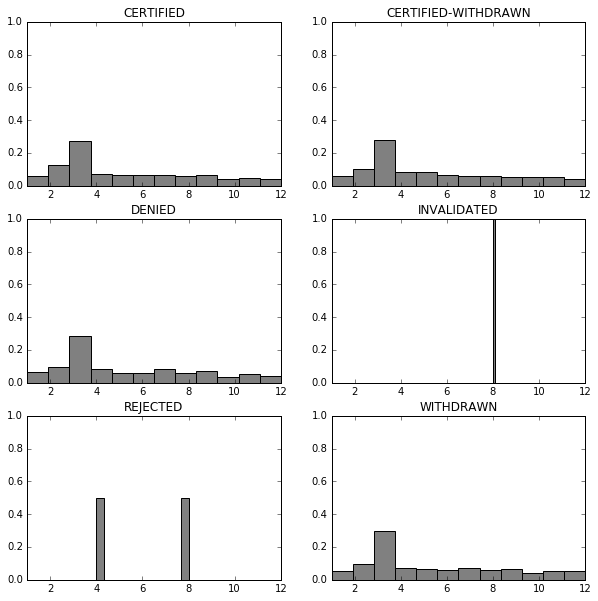

In [45]:
#explore the feature
featureExplore(df,'submitMonth',12)

Feature: month of submission  
More applications are submitted in February and March than any other time but the pattern appears to be very similar for certified vs. denied so there

** Create a variable for length of employment **

In [47]:
#convert employment start date and end date to date format
df.loc[:,'empStartDate'] = pd.to_datetime(df['lca_case_employment_start_date'])
df.loc[:,'empEndDate'] = pd.to_datetime(df['lca_case_employment_end_date'])
#get the length of employment in days
df.loc[:,'empLength'] = (df['empEndDate'] - df['empStartDate']).dt.days.round(0)

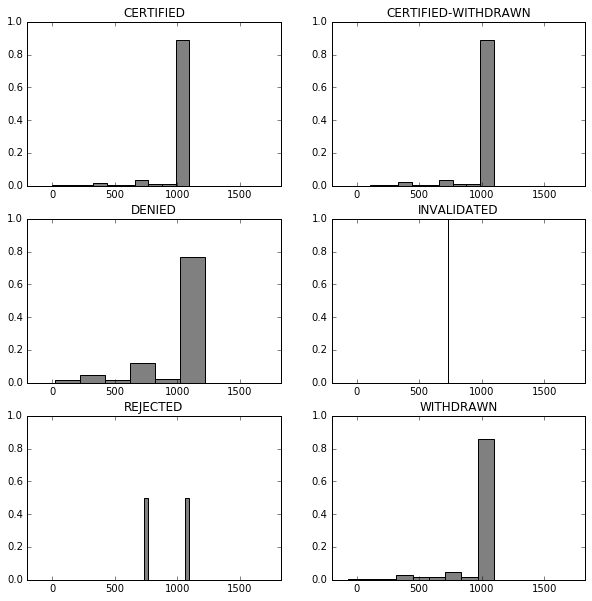

In [48]:
#explore the feature
featureExplore(df,'empLength',10)

Timeframes shorter than 1000 days seem somewhat more likely to be denied - possible feature

** Create a variable for FT vs PT **

In [50]:
#convert FT to 1 and PT to 0
df.loc[:,'FT'] = df['full_time_pos'].map({'Y': 1, 'N': 0})

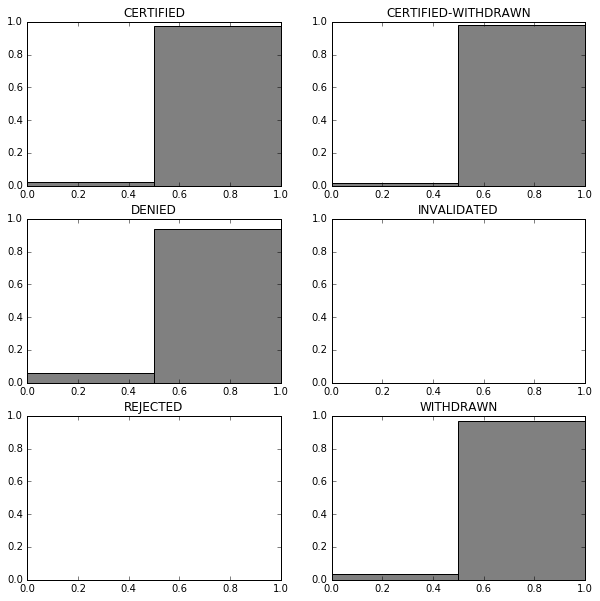

In [51]:
featureExplore(df,'FT',2)

A slightly larger percentage of part time are denied - possible feature

** number of workers **

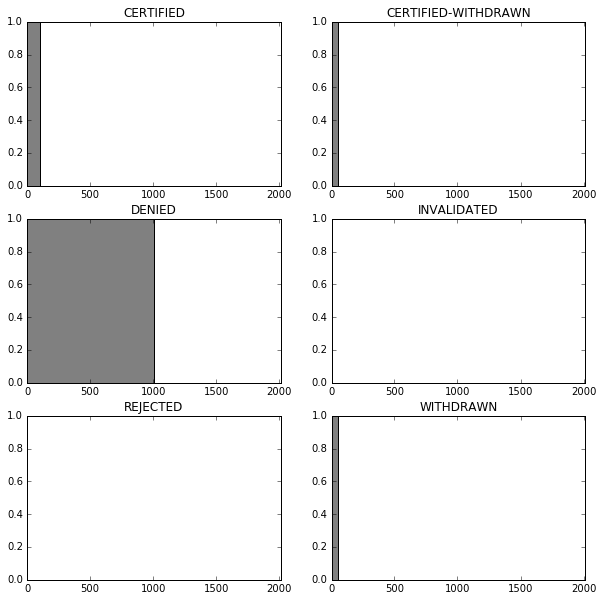

In [52]:
featureExplore(df,'total_workers',2)

In [53]:
#look at more information

#look at the counts
workers = df['total_workers'].tolist()
Counter(workers)

Counter({nan: 1,
         1.0: 472897,
         2.0: 7904,
         3.0: 5002,
         4.0: 1718,
         5.0: 6504,
         6.0: 1708,
         7.0: 680,
         8.0: 582,
         9.0: 171,
         10.0: 8376,
         11.0: 61,
         12.0: 133,
         13.0: 36,
         14.0: 37,
         15.0: 4675,
         16.0: 44,
         17.0: 14,
         18.0: 29,
         19.0: 7,
         20.0: 3406,
         21.0: 14,
         22.0: 14,
         23.0: 10,
         24.0: 21,
         25.0: 1390,
         26.0: 10,
         27.0: 1,
         28.0: 8,
         29.0: 5,
         30.0: 2153,
         nan: 1,
         32.0: 4,
         33.0: 1,
         34.0: 1,
         35.0: 66,
         36.0: 9,
         37.0: 1,
         40.0: 244,
         42.0: 5,
         43.0: 12,
         44.0: 1,
         45.0: 14,
         46.0: 7,
         48.0: 1,
         50.0: 882,
         55.0: 20,
         59.0: 1,
         60.0: 56,
         65.0: 18,
         nan: 1,
         70.0: 17,
         75

In [55]:
#group by status and total workers, then view distribution
workerStatus = df.groupby(['status', 'total_workers']).size()
workStatD = workerStatus['DENIED']
workStatC = workerStatus['CERTIFIED']

certTotal = statusDist.get('CERTIFIED')
denTotal = statusDist.get('DENIED')

print workStatC.astype(np.float32) / certTotal
print workStatD.astype(np.float32) / denTotal

total_workers
1.0      0.904551
2.0      0.014743
3.0      0.010267
4.0      0.003280
5.0      0.013409
6.0      0.003572
7.0      0.001419
8.0      0.001217
9.0      0.000360
10.0     0.017676
11.0     0.000101
12.0     0.000270
13.0     0.000066
14.0     0.000075
15.0     0.010039
16.0     0.000086
17.0     0.000029
18.0     0.000059
19.0     0.000015
20.0     0.007264
21.0     0.000031
22.0     0.000031
23.0     0.000015
24.0     0.000046
25.0     0.002872
26.0     0.000022
27.0     0.000002
28.0     0.000018
29.0     0.000011
30.0     0.004418
32.0     0.000009
33.0     0.000002
34.0     0.000002
35.0     0.000143
36.0     0.000020
37.0     0.000002
40.0     0.000497
42.0     0.000011
43.0     0.000026
44.0     0.000002
45.0     0.000031
46.0     0.000015
48.0     0.000002
50.0     0.001903
55.0     0.000044
59.0     0.000002
60.0     0.000123
65.0     0.000035
70.0     0.000033
75.0     0.000059
80.0     0.000002
86.0     0.000002
90.0     0.000002
99.0     0.000002
100.0    0.001

In [56]:
#get a df with applications with more than one worker
dfWorkerGtr1 = df[ df['total_workers'] > 1 ]
dfWorker1_20 = df[ (df['total_workers'] >= 1) & (df['total_workers'] <= 20) ] 
dfWorker20_50 = df[ (df['total_workers'] > 20) & (df['total_workers'] <= 50) ] 

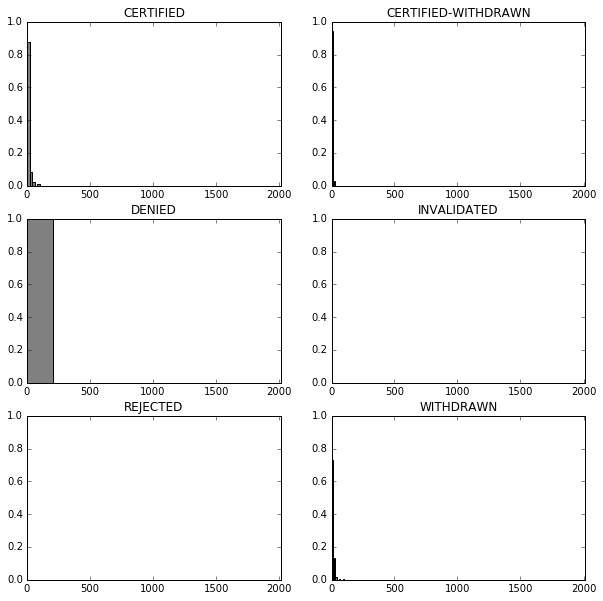

In [57]:
featureExplore(dfWorkerGtr1,'total_workers',10)

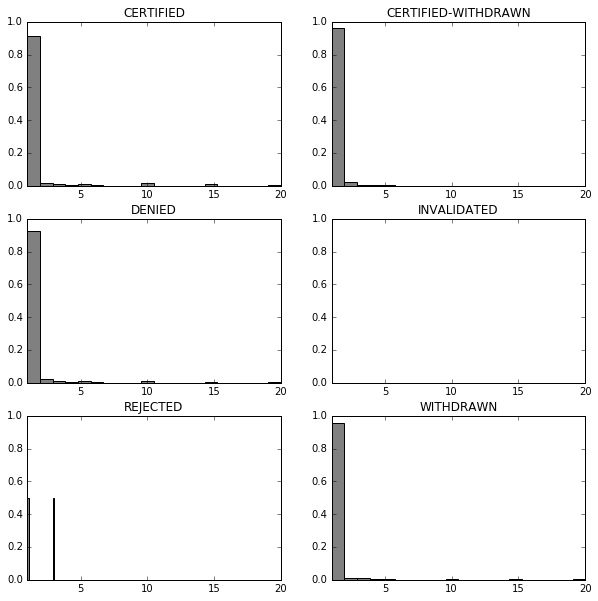

In [59]:
featureExplore(dfWorker1_20,'total_workers',20)

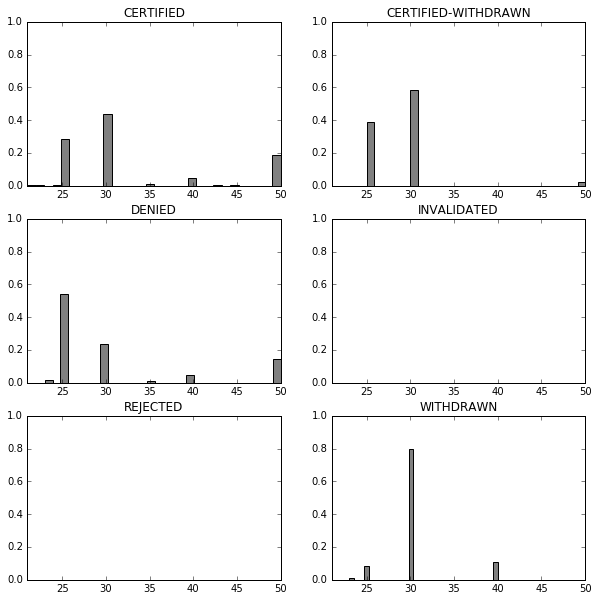

In [58]:
featureExplore(dfWorker20_50,'total_workers',30)

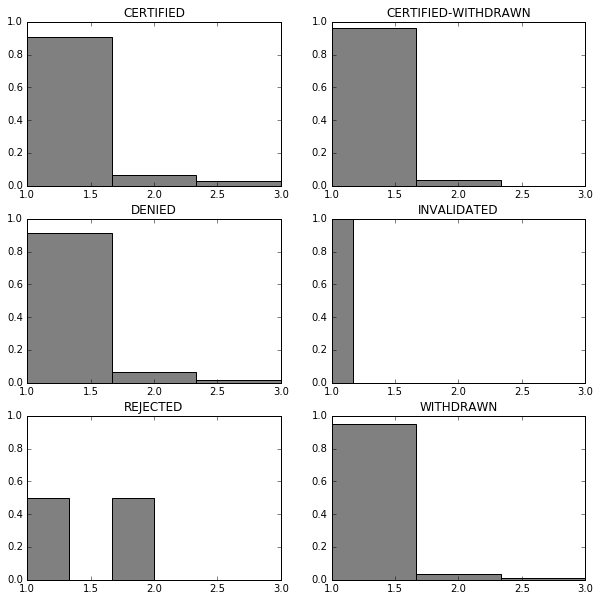

In [60]:
#set up a new field that has 1 workers, 2 to 10 workers, more than 10 workers
df.loc[df['total_workers'] == 1, 'workerCategory'] = 1
df.loc[(df['total_workers'] > 1) & (df['total_workers'] <=10), 'workerCategory'] = 2
df.loc[df['total_workers'] >10 , 'workerCategory'] = 3


featureExplore(df,'workerCategory',3)

There are no obvious patterns in the number of workers

Location (group by region to simplify)

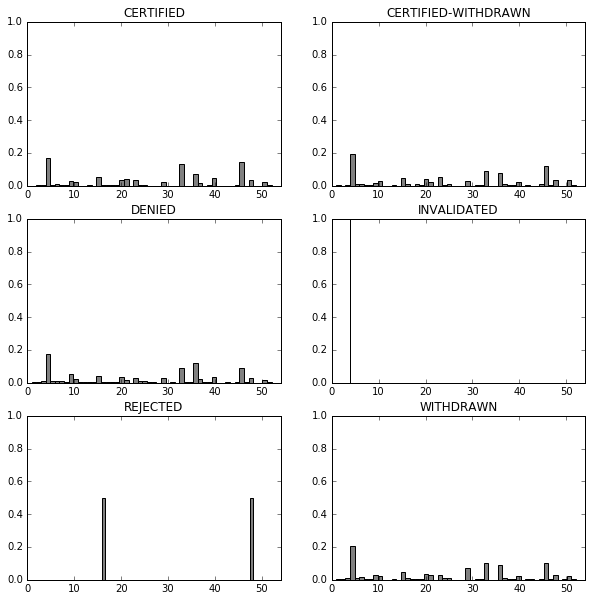

In [62]:
#get all states using the employer state
states = list(set(df['lca_case_employer_state'].dropna().tolist()))
states.sort()

#set up a blank dictionary
stateMap = {}
#maps the states to numbers
for i,state in enumerate(states):
    stateMap.update({state:i})

#change state name to mapping number
df['empState'] = df['lca_case_employer_state'].map(stateMap)

#view charts
featureExplore(df,'empState',len(states))


There are no obvious pattern differences by employer state

** Proposed wage rate for annual wages under $500,000 **

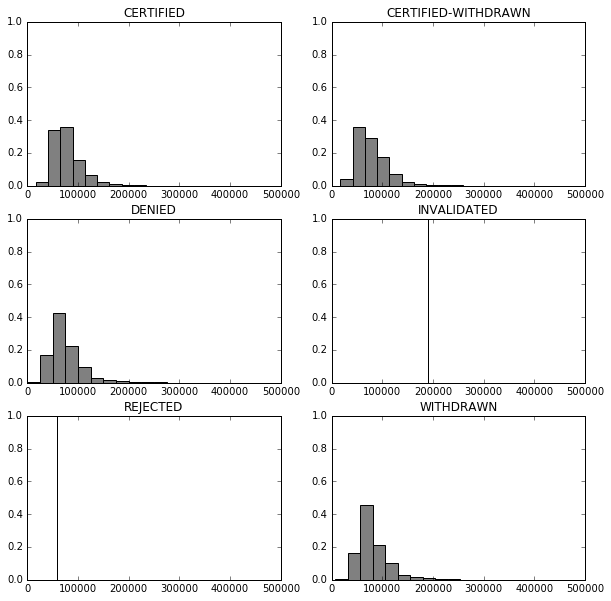

In [63]:
dfWages = df[(df['lca_case_wage_rate_from'] <=500000) & (df['lca_case_wage_rate_unit'] == 'Year')]
featureExplore(dfWages,'lca_case_wage_rate_from',20)

** Step 2 **
** Narrow to the 3 features based on data exploration **

Based on data exploration only 3 features are worth testing, but even these seem unlikely to produce statistically signficant results

feature 1 - employment length  
feature 2 - full time vs part time  
feature 3 - proposed wage rate  

** Step 3 **  
Since we don't have enough information about "withdrawn" applications, 
remove these from the data set, include "Certified" and "Denied"

In [65]:
#get only status 'DENIED','CERTIFIED' and only wages that are annual 00
dfCertDen = dfWages[ (dfWages['status'] == 'DENIED') | (dfWages['status'] == 'CERTIFIED') ]

In [66]:
#set up a target field that has 1 for denied, 0 for certifiedand less then 500,0
dfCertDen.loc[df['status'] == 'DENIED', 'statusTarget'] = 1
dfCertDen.loc[df['status'] == 'CERTIFIED', 'statusTarget'] = 0

** Step 4 ** 
Run a logistic regression and evaluate the results

In [67]:
# create dataframes with an intercept column 
y, X = dmatrices('statusTarget ~ empLength + lca_case_wage_rate_from + FT',dfCertDen, return_type="dataframe")

# flatten y into a 1-D array
y = np.ravel(y)

In [68]:
# logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
accuracy = model.score(X, y)
print accuracy

# what percentage were denied?
y.mean()
print 1 - y.mean()

0.977375387969
0.977375387969


In [69]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[-2.83985018561e-06]
1,empLength,[-0.00242341080637]
2,lca_case_wage_rate_from,[-1.71859696893e-05]
3,FT,[-2.87973111705e-06]


The logistic regression accuracy is no better than the null rate, so these features do not provide any additional information or form a useful model for predicting whether an application will be denied.

There may be other factors that were not considered, or it may just not be possible to predict the status based on this data set